# Evaluate on OSC task

In [1]:
import pickle
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve

import cs
from tools.utils import to_device, get_test_set_loader
from tasks.bert_classifier.utils import get_model, get_test_set, get_osc_set
from tasks.bert_classifier.train import train
from tasks.bert_classifier.predict_new import bert_classifier_predict, bert_classifier_validation, bert_classifier_predict_new
from tasks.bert_classifier.predict_new import bert_classifier_test_detail, bert_classifier_test_detail_result

In [2]:
id_to_cls = pickle.load(open('/home/jxqi/ACL/experiment/ann/dataset/id_to_cls.pkl', 'rb'))
cls_to_id = { v:k for k,v in id_to_cls.items() }

## Load model

In [3]:
model = get_model(last_training_time=1622731763, last_step='02971')

In [4]:
save_test_root = '/home/datamerge/ACL/Data/210422/test/'
save_pkl_root = '/home/datamerge/ACL/Data/210422/pkl/'

osc_filepath = save_test_root+'osc.txt'
nor2len_dict = pickle.load(open(save_pkl_root+'210422_nor2len_dict.pkl', 'rb'))

In [5]:
osc_dataset = get_osc_set(osc_filepath)

In [6]:
pred, true, prob = bert_classifier_predict_new(model, osc_dataset)

100%|██████████| 402/402 [07:59<00:00,  1.19s/it]


(102674,) (102674,) (102674,)


In [10]:
osc_length = []
with open(osc_filepath, 'r', encoding='utf-8') as f:
    for line in f:
        ori, nor, open_label = line.replace("\n", "").split("\t\t")
        length = nor2len_dict[nor]
        osc_length.append(length)
    f.close()

In [12]:
def report_osc(y, scores):
    fpr, tpr, thresholds = roc_curve(y, scores)  
    return fpr, tpr, thresholds


def calc_split(low_margin, high_margin, y, scores, test_set_size):
    low = test_set_size < low_margin
    high = test_set_size > high_margin
    mid = np.logical_and(test_set_size >= low_margin, test_set_size <= high_margin)

    r1 = report_osc(y[high], scores[high])
    r2 = report_osc(y[mid], scores[mid])
    r3 = report_osc(y[low], scores[low])
    
    return r1, r2, r3

In [13]:
def evaluate_osc(true, probs, osc_length):
    '''
    Input:
        true: true label value， like an array([   -1,    -1,    -1,  6739, 20992,    -1,    -1, 20206,    -1,   -1]), note that -1 here are denoted open test set
        probs: The predicted probability value of the category (that is, the probability value of the category with the highest predicted probability value)
        osc_length: The number of variations in the category of each sample used to differentiate the performance of the various sections of the statistics (High, Middle, Few)
    Output:
        (
            overall, :a dict contain overall performance, it includes two keys named 'tpr' and 'fpr'
            part, :a dict contain performance of different subset 
        )
    '''
    open_labels = true < 0
    probability = 1 - probs
    test_set_size = np.array(osc_length)
    
    fpr, tpr, thresholds = report_osc(open_labels, probability)
    overall = {
        'fpr': fpr,
        'tpr': tpr,
    }
    high, middle, few = calc_split(5, 20, open_labels, probability, test_set_size)
    part = {
        'high':{
            'fpr': high[0],
            'tpr': high[1],
        },
        'middle':{
            'fpr': middle[0],
            'tpr': middle[1],
        }, 
        'few':{
            'fpr': few[0],
            'tpr': few[1],
        },     
    }
    return (overall, part)

In [14]:
overall, part = evaluate_osc(true, prob, osc_length)

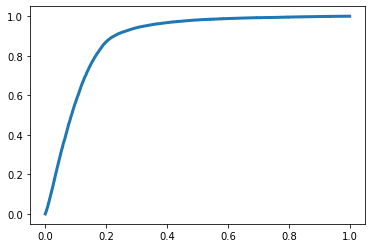

In [15]:
from matplotlib import pyplot as plt

plt.plot(overall['fpr'], overall['tpr'], label="BERT Overall",  linewidth=3, linestyle='-')
plt.show()

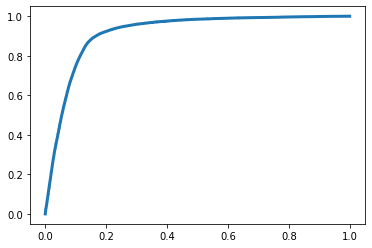

In [16]:
plt.plot(part['high']['fpr'], part['high']['tpr'], label="BERT High",  linewidth=3, linestyle='-')
plt.show()

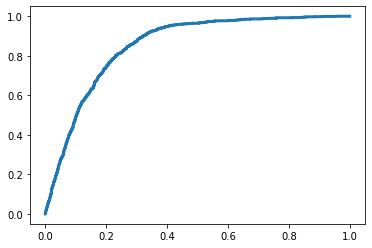

In [17]:
plt.plot(part['middle']['fpr'], part['middle']['tpr'], label="BERT Middle",  linewidth=3, linestyle='-')
plt.show()

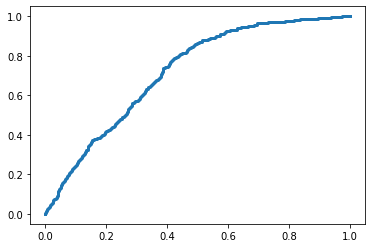

In [18]:
plt.plot(part['few']['fpr'], part['few']['tpr'], label="BERT Few",  linewidth=3, linestyle='-')
plt.show()

In [19]:
result = {
    'overall': overall,
    'part': part
}

In [20]:
pickle.dump(result, open("./osc/cbert_rs3_osc.pkl", "wb"))